<center>

**ĐẠI HỌC QUỐC GIA THÀNH PHỐ HỒ CHÍ MINH**

**TRƯỜNG ĐẠI HỌC KHOA HỌC TỰ NHIÊN**

**KHOA TOÁN - TIN HỌC**

<img src="https://drive.google.com/uc?id=1ExqQRbST3nEi5nD4Gm_mKhi9qVD2VYes" alt="Mô tả ảnh" width="200px">


PYTHON CHO KHOA HỌC DỮ LIỆU

---

BÁO CÁO CUỐI KỲ

Đề tài: Customer Churn Prediction for Sparkify using PySpark

---

</center>

Giảng viên: Thầy Hà Văn Thảo

SV thực hiện:
<ul>
    <li>Trần Ngọc Dễ - 21110057</li>
    <li>Huỳnh Nguyễn Thế Dân - 21110256</li>
    <li>Nguyễn Duy Đạt - 21110256</li>
</ul>


# Customer Churn Prediction for Sparkify using PySpark

## Giới thiệu


Dự đoán tỷ lệ khách hàng rời đi là một vấn đề khó khăn và phổ biến đối với bất kỳ doanh nghiệp thương mại điện tử nào, nơi mọi thứ phụ thuộc vào hành vi của khách hàng. Tỷ lệ khách hàng rời đi thường được định nghĩa là quá trình mà khách hàng giảm cấp từ dạng cao cấp xuống dạng miễn phí hoặc ngừng sử dụng sản phẩm hoặc dịch vụ của doanh nghiệp. Do đó, dự đoán khả năng những người dùng có nguy cơ rời đi trong khi vẫn còn thời gian đăng ký hay sử dụng từ đó nhầm để đề xuất cho họ các ưu đãi hoặc khuyến mãi khác, việc này sẽ giúp rất nhiều trong việc ngăn chặn doanh nghiệp phải gánh chịu những tổn thất tài chính nặng nề.

Sparkify là một dịch vụ nghe nhạc hư cấu, được Udacity tạo ra để mô phỏng các bộ dữ liệu được tạo ra bởi các công ty như Spotify hoặc Pandora. Hàng triệu người dùng hàng ngày nghe những bài hát yêu thích của họ thông qua các dịch vụ như vậy, người dùng có thể truy cập dịch vụ thông qua gói miễn phí, bao gồm quảng cáo giữa các bài hát hoặc thông qua gói đăng ký cao cấp (premium), trong đó họ phải trả một khoản phí cố định hàng tháng để phát trực tuyến không có quảng cáo. Người dùng có thể nâng cấp gói hoặc giảm cấp gói đăng ký bất kỳ lúc nào, nhưng cũng có thể hủy nó hoàn toàn. Tập dữ liệu đầy đủ thu thập hơn 26 triệu bản ghi từ 22277 người dùng đã đăng ký, trong khi tập dữ liệu nhỏ chứa 286500 bản ghi từ 225 người dùng đã đăng ký với thời lượng khoảng hai tháng.

 Bằng cách xác định chính xác những người dùng có khả năng rời đi, Sparkify có thể cung cấp cho họ các khoản giảm giá và ưu đãi nhằm cố gắng giữ chân họ. Tuy nhiên, điều quan trọng là tránh dự đoán sai tỷ lệ rời đi đối với những người dùng có khả năng vẫn trung thành vì việc đưa ra các khoản giảm giá và ưu đãi rất tốn kém. Và mục tiêu của chúng tôi là xây dựng và huấn luyện bộ phân loại nhị phân (binary classifier) có khả năng xác định chính xác những người dùng (cả ở dạng miễn phí và trả phí) đã hủy dịch vụ nghe nhạc Sparkify, dựa trên các dữ liệu thu được từ hoạt động và tương tác trước đây của người dùng với dịch vụ.

 Dự án bao gồm các bước chính:
- Load & Data Cleaning
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Modeling
- Model Evaluation and Validation


In [229]:
# Import các thư viện cần thiết cho xử lý và phân tích dữ liệu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.sparse import csr_matrix  # Ma trận thưa thớt
from scipy.sparse.csgraph import connected_components  # Tính các thành phần liên thông trong đồ thị
from time import time  # Hàm đo thời gian

# Import các module từ PySpark để xử lý dữ liệu lớn
from pyspark.sql import SparkSession, Window  # Các phần cơ bản của Spark
from pyspark.sql.functions import *  # Các hàm xử lý dữ liệu trong Spark
from pyspark.sql.types import IntegerType  # Kiểu dữ liệu nguyên trong Spark

# Import các class và module từ PySpark MLlib để xây dựng và đánh giá mô hình machine learning
from pyspark.ml.stat import Correlation  # Tính toán ma trận tương quan
from pyspark.ml.feature import MinMaxScaler, VectorAssembler  # Chuẩn hóa và tạo vector thuộc tính
from pyspark.ml import Pipeline  # Xây dựng pipeline xử lý dữ liệu
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier  # Các mô hình phân loại
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder  # Tinh chỉnh mô hình
from pyspark.ml.evaluation import BinaryClassificationEvaluator  # Đánh giá mô hình phân loại
from pyspark.mllib.evaluation import MulticlassMetrics  # Đánh giá đa lớp

# Tắt các cảnh báo hiển thị để làm cho kết quả chạy sạch sẽ hơn
import warnings
warnings.filterwarnings("ignore")

In [230]:
# Tạo một phiên làm việc của Spark
spark = SparkSession.builder.master("local[*]").appName("Sparkify").getOrCreate()

Câu Lệnh này tạo một phiên Spark trong môi trường Apache Spark.

- SparkSession.builder: Bắt đầu quá trình xây dựng một phiên Spark.
- .master("local[*]"): Xác định chế độ chạy của Spark. Trong trường hợp này, "local[*]" đề cập đến việc sử dụng tất cả các lõi CPU có sẵn trên máy cục bộ để thực hiện công việc.
- .appName("Sparkify"): Đặt tên cho ứng dụng Spark, trong trường hợp này là "Sparkify".
- .getOrCreate(): Tạo hoặc trả về một phiên Spark hiện tại nếu nó đã tồn tại.

Do đó, câu lệnh này tạo một phiên Spark mới hoặc sử dụng phiên Spark hiện tại có tên là "Sparkify" với chế độ chạy là local[*], sử dụng tất cả các lõi CPU có sẵn trên máy. Điều này là bước cần thiết để bắt đầu làm việc với dữ liệu và thực hiện các phép toán tính toán trong môi trường Spark.

## Data Cleaning

In [231]:
# Đọc dữ liệu từ tệp JSON vào DataFrame sử dụng Spark
df = spark.read.json("mini_sparkify_event_data.json")

# In ra cấu trúc (schema) của DataFrame
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [232]:
# In ra số lượng hàng trong DataFrame
print('Bộ dữ liệu chứa {} hàng.'.format(df.count()))

Bộ dữ liệu chứa 286500 hàng.


In [233]:
# Hiển thị 5 hàng đầu tiên của DataFrame và chuyển đổi thành DataFrame Pandas
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


#### Kiểm tra giá trị của các biến phân loại mà ta quan tâm

In [234]:
df.select('auth').distinct().collect()

[Row(auth='Logged Out'),
 Row(auth='Cancelled'),
 Row(auth='Logged In'),
 Row(auth='Guest')]

In [235]:
df.select('gender').distinct().collect()

[Row(gender='F'), Row(gender='M'), Row(gender=None)]

In [236]:
df.select('level').distinct().collect()

[Row(level='free'), Row(level='paid')]

In [237]:
df.select('method').distinct().collect()

[Row(method='PUT'), Row(method='GET')]

In [238]:
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade'),
 Row(page='Register'),
 Row(page='Submit Registration')]

#### Kiểm tra khoảng thời gian mà Bộ dữ liệu thu thập các bản ghi

In [239]:
df.select(min(to_timestamp(col('ts')/1000)).alias('Start time')).show()

+-------------------+
|         Start time|
+-------------------+
|2018-10-01 07:01:57|
+-------------------+



In [240]:
df.select(max(to_timestamp(col('ts')/1000)).alias('End time')).show()

+-------------------+
|           End time|
+-------------------+
|2018-12-03 08:11:16|
+-------------------+



Thời gian thu thập dữ liệu nằm trong khoảng 2 tháng

#### Kiểm tra những dữ liệu bị rỗng (NULL)

In [241]:
# Kiểm tra số lượng giá trị null trong mỗi cột và chuyển đổi thành DataFrame Pandas
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


Chúng ta có thể thấy rằng các biến có giá trị null có thể chia thành 2 nhóm như sau:

* Nhóm 1 (Liên quan đến người dùng) bao gồm: firstName, gender, lastName, location, registration and userAgent
* Nhóm 2 (Liên quan đến bài hát) bao gồm: artist, length and song

Các biến trong từng nhóm có vẻ được gắn với 1 giá trị rỗng theo một cách nhất định.

In [242]:
df.where('firstName is null').limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,
5,None,Logged Out,None,None,3,None,NaN,free,None,PUT,Login,NaN,240,None,307,1538356679000,None,
6,None,Logged Out,None,None,0,None,NaN,free,None,PUT,Login,NaN,100,None,307,1538358102000,None,
7,None,Logged Out,None,None,0,None,NaN,free,None,PUT,Login,NaN,241,None,307,1538360117000,None,
8,None,Logged Out,None,None,14,None,NaN,free,None,GET,Home,NaN,187,None,200,1538361527000,None,
9,None,Logged Out,None,None,15,None,NaN,free,None,PUT,Login,NaN,187,None,307,1538361528000,None,


Có thể nhận thấy rằng khi **auth** là *LoggedOut* thì các biến trong cả 2 nhóm đều là null và **userId** là một chuỗi rỗng.

In [243]:
# Lọc các hàng trong DataFrame có giá trị null trong cột 'userId'
# Sau đó nhóm các hàng theo giá trị trong cột 'auth' và đếm số lượng hàng trong mỗi nhóm
df.where(df['userId'] == '').groupBy('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



Kết quả ở trên hiển thị tất cả các hàng có giá trị trong cột **userId** là rỗng và tất cả các cột khác liên quan đến việc người dùng đã *Logged Out* hoặc là *Guest*.

In [244]:
df.where('artist is null').limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
4,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
5,None,Logged In,Micah,M,95,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Down,1.538332e+12,8,None,307,1538355306000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,None,Logged In,Micah,M,97,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Home,1.538332e+12,8,None,200,1538355504000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,None,Logged In,Micah,M,99,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Logout,1.538332e+12,8,None,307,1538355687000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
8,None,Logged In,Ashlynn,F,9,Williams,NaN,free,"Tallahassee, FL",PUT,Thumbs Up,1.537365e+12,217,None,307,1538355711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",74
9,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,


In [245]:
set(df.select('page').distinct().collect())-set(df.select('page').where('artist is null').distinct().collect())

{Row(page='NextSong')}

Ta nhận thấy rằng các biến trong nhóm 2 là null bất cứ khi nào **page** không phải là *NextSong*, điều này hợp lý vì các biến này có liên quan đến bài hát.

In [246]:
def clean_data(df):
    """Clean a Sparkify dataset

    Args:
    df: (spark dataframe) a Sparkify dataset

    Returns:
    df: (spark dataframe) a preprocessed Sparkify dataset
    """
    # loại bỏ những user id rỗng
    df = df.filter(df['userId'] != '')

    # chuyển 'registration' and 'ts' thành date format
    df = df \
        .withColumn('registrationTime', to_timestamp(col('registration')/1000)) \
        .withColumn('time', to_timestamp(col('ts')/1000))

    # ghi đè địa chỉ với list đầu tiên của tiểu bang
    state_udf = udf(lambda x: x.split(', ')[1].split('-')[0])
    df = df.withColumn('location', state_udf('location'))

    return df

df = clean_data(df)

## Feature Engineering and Exploratory Data Analysis

Sau khi đã làm quen với dữ liệu, ta tiến hành xây dựng các đặc trưng (feature) mà ta thấy có tiềm năng và thực hiện phân tích dữ liệu để quan sát sự khác biệt về nhân khẩu học và hành vi giữa những người dùng ở lại và những người dùng rời đi.

### Xác định tỷ lệ rời đi

Đầu tiên, sử dụng các sự kiện *Cancellation Confirmation* trong cột **page** để xác định việc khách hàng chấm dứt sử dụng dịch vụ.

In [247]:
# Tạo một cửa sổ được phân vùng theo 'userId'
userWindow = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)

In [248]:
# Gắn nhãn người dùng rời đi là 1 và người dùng chưa rời là 0
df = df \
    .withColumn('Churn', when(col('page')=='Cancellation Confirmation', 1).otherwise(0)) \
    .withColumn('Churn', max('Churn').over(userWindow))

/******

- userWindow: Được tạo ra là một cửa sổ (window) dữ liệu được phân chia theo cột 'userId' và sắp xếp theo cột 'ts' (timestamp). Cửa sổ này bao gồm tất cả các dòng từ vô cực trước đến vô cực sau (tức là không giới hạn).
- .withColumn('Churn', when(col('page')=='Cancellation Confirmation', 1).otherwise(0)): Tạo một cột mới có tên là 'Churn' trong DataFrame. Nếu giá trị trong cột 'page' là 'Cancellation Confirmation', giá trị của cột 'Churn' sẽ là 1, ngược lại sẽ là 0. Điều này có nghĩa là nếu có sự kiện xác nhận hủy bỏ ('Cancellation Confirmation'), người dùng được đánh dấu là đã churn (1), ngược lại là không churn (0).
- .withColumn('Churn', max('Churn').over(userWindow)): Sử dụng hàm window max để gán giá trị 'Churn' là giá trị lớn nhất của cột 'Churn' trong cửa sổ dữ liệu (window) đã được định nghĩa trước đó. Điều này có tác dụng "lấy" giá trị churn (1) trên tất cả các dòng của mỗi người dùng nếu họ có ít nhất một sự kiện xác nhận hủy bỏ.

Đoạn này đang thêm một cột mới 'Churn' vào DataFrame để đánh dấu liệu người dùng có churn (1) hay không churn (0) dựa trên sự kiện xác nhận hủy bỏ ('Cancellation Confirmation'). Các thao tác này giúp xác định người dùng đã chấm dứt sử dụng dịch vụ (churned users).


In [249]:
df.dropDuplicates(['userId']).groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



/*****

Tính toán và hiển thị số lượng người dùng duy nhất trong mỗi nhóm churn (Churn), với một nhóm là người dùng đã rời đi và một nhóm là người dùng không rời đi. Điều này giúp ta có cái nhìn tổng quan về phân phối của hai nhóm này trong dữ liệu.

Có 52 người dùng đã rời đi trong tổng số 225 người dùng trong tập dữ liệu. Ta có tỷ lệ rời đi khoảng 23,1%.

### Xây dựng các tính năng

Tiếp theo, ta kiểm tra các yếu tố sau đây để tìm hiểu về sự ảnh hưởng của chúng đối với việc chấm dứt sử dụng dịch vụ:

- Giới tính (gender)
- Địa điểm (location)
- Cấp độ mới nhất (latest level)
- Thời gian đăng ký (registration duration)
- Thời lượng trung bình của mỗi phiên kết nối (average session duration)
- Các hoạt động được tổng hợp / quan sát trong một khoảng thời gian

Trong danh sách này, giới tính và địa điểm đại diện cho thông tin của người dùng. Và nhận thấy rằng người dùng của Sparkify đến từ 41 tiểu bang khác nhau. Nếu sử dụng mã hóa one-hot cho đặc trưng địa điểm thì sẽ thêm vào 40 cột nhị phân cho mỗi mẫu trong một tập dữ liệu chỉ có 225 mẫu, điều này có thể gây ra vấn đề về số chiều (curse of dimensionality). Để giải quyết vấn đề này, ta có thể thay thế mỗi tiểu bang bằng khu vực địa lý tương ứng (nguồn dữ liệu: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf) để chỉ định 41 tiểu bang thành 9 phân khu.

In [250]:
# In ra số lượng tiểu bang trong tập dữ liệu
print('Bộ dữ liệu bao gồm {} tiểu bang.'.format(df.dropDuplicates(['location']).count()))

Bộ dữ liệu bao gồm 41 tiểu bang.


/****
Đoạn mã này sử dụng dropDuplicates(['location']) để loại bỏ các dòng trùng lặp dựa trên cột 'location', sau đó tính số lượng tiểu bang còn lại trong tập dữ liệu và in ra màn hình thông qua hàm print.

In [251]:
# Đọc dữ liệu từ tệp tin CSV 'us_regions.csv' và gán cho DataFrame 'region_df
region_df = spark.read.csv('us_regions.csv', header=True)

# Hiển thị 5 dòng đầu tiên của DataFrame 'region_df'
region_df.show(5)

+----------+----------+------+------------------+
|     State|State Code|Region|          Division|
+----------+----------+------+------------------+
|    Alaska|        AK|  West|           Pacific|
|   Alabama|        AL| South|East South Central|
|  Arkansas|        AR| South|West South Central|
|   Arizona|        AZ|  West|          Mountain|
|California|        CA|  West|           Pacific|
+----------+----------+------+------------------+
only showing top 5 rows



In [252]:
# Tìm khu vực địa lý của người dùng dựa trên địa điểm
division_udf = udf(lambda x: 'location' + x.replace(' ', ''))

location_df = df.select(['userId', 'location']).dropDuplicates(['userId'])
location_df = location_df.join(region_df, location_df['location']==region_df["State Code"], how='left') \
            .select(['userId', col("Division").alias("location")]) \
            .withColumn('location', division_udf('location'))

# Mã hóa one-hot cho cột 'location'
location_df = location_df.groupBy('userId').pivot('location').agg(count('location').cast(IntegerType())).fillna(0)

# Loại bỏ cột cuối cùng (hoặc bất kỳ cột nào) để giữ cho các cột nhị phân độc lập
location_df = location_df.drop(location_df.columns[-1])

location_df.limit(5).toPandas()

,userId,locationEastNorthCentral,locationEastSouthCentral,locationMiddleAtlantic,locationMountain,locationNewEngland,locationPacific,locationSouthAtlantic,locationWestNorthCentral
0,200002,1,0,0,0,0,0,0,0
1,100010,0,0,0,0,1,0,0,0
2,125,0,0,0,0,0,0,0,0
3,124,0,0,1,0,0,0,0,0
4,7,0,0,0,0,0,1,0,0


/*****
- "division_udf = udf(lambda x: 'location' + x.replace(' ', ''))": Tạo một UDF để biến đổi giá trị trong cột 'location' của DataFrame theo một quy tắc nhất định. Trong trường hợp này, giá trị 'location' sẽ được thêm tiền tố 'location' và khoảng trắng sẽ được thay thế bằng ''.
- Tạo một DataFrame mới location_df từ DataFrame gốc df với các bước sau:
Lấy ra các cột 'userId' và 'location', loại bỏ các dòng trùng lặp theo 'userId'.
Kết hợp với DataFrame region_df theo điều kiện 'location' của location_df bằng với 'State Code' của region_df. Chọn các cột 'userId' và 'Division' (alias thành 'location'). Áp dụng UDF để biến đổi giá trị trong cột 'location' theo quy tắc đã định nghĩa.
- Sử dụng groupBy và pivot để thực hiện mã hóa one-hot cho cột 'location' dựa trên 'userId'. Sử dụng hàm tổng (count) để tính số lượng xuất hiện của mỗi giá trị 'location' cho mỗi 'userId'. Ép kiểu dữ liệu của các cột thành kiểu Integer.Điền giá trị thiếu (NaN) bằng 0. Loại bỏ cột cuối cùng (hoặc bất kỳ cột nào) để giữ cho các cột nhị phân độc lập.


Bây giờ chúng ta sẽ tạo ra những đặc trưng còn lại, tất cả liên quan đến hành vi của người dùng.

In [253]:
# Tìm cấp độ mới nhất của mỗi người dùng
df = df.withColumn('latestLevel', last(col('level')).over(userWindow))

/****

Thêm một cột mới vào DataFrame df để lưu trữ cấp độ mới nhất của mỗi người dùng dựa trên một đặc tả cửa sổ được xác định trước (userWindow).

- df: DataFrame chứa dữ liệu người dùng.
- withColumn: Phương thức của PySpark được sử dụng để thêm một cột mới hoặc thay thế một cột hiện tại trong DataFrame.
- 'latestLevel': Tên của cột mới sẽ lưu trữ cấp độ mới nhất cho mỗi người dùng.
- last(col('level')): Hàm cửa sổ last được áp dụng cho cột 'level'. Hàm này trả về giá trị cuối cùng không rỗng trong cửa sổ.
- .over(userWindow): Xác định đặc tả cửa sổ (userWindow) để xác định phạm vi hoặc phân đoạn mà hàm cửa sổ hoạt động. Nó xác định cách các hàng được nhóm và được sắp xếp.

Điều này giúp tạo ra một bảng dữ liệu mới chứa thông tin về cấp độ mới nhất của mỗi người dùng, dựa trên thông tin cấp độ trong cột 'level' và sắp xếp thời gian bằng đặc tả cửa sổ userWindow. Điều này thường hữu ích trong việc phân tích dữ liệu theo thời gian và theo dõi sự thay đổi của các thông tin cấp độ của người dùng theo thời gian.

In [254]:
# Tính khoảng thời gian từ khi đăng ký đến hoạt động cuối cùng (tính theo ngày)
regist_duration_df = df.groupBy('userId') \
                    .agg(((last(col('ts'))-last(col('registration')))/1000/3600/24).alias('registDuration'))

/****

df.groupBy('userId'):

Nhóm dữ liệu theo cột 'userId', tức là tạo các nhóm dữ liệu riêng biệt cho mỗi người dùng.
.agg(...):

Thực hiện các phép tổng hợp (aggregation) trên từng nhóm người dùng.
((last(col('ts')) - last(col('registration'))) / 1000 / 3600 / 24):

Tính toán khoảng thời gian giữa thời điểm hoạt động cuối cùng ('ts') và thời điểm đăng ký ('registration') của người dùng.
(last(col('ts')) - last(col('registration'))) tính sự chênh lệch giữa thời điểm hoạt động cuối cùng và thời điểm đăng ký.
/ 1000 / 3600 / 24: Chuyển đổi kết quả từ mili giây sang giây, giây sang giờ, và giờ sang ngày.
.alias('registDuration'):

Đặt tên cho cột kết quả là 'registDuration' để làm cho nó rõ ràng và dễ hiểu.
Vì vậy, regist_duration_df là một DataFrame mới chứa thông tin về khoảng thời gian giữa thời điểm đăng ký và thời điểm hoạt động cuối cùng của mỗi người dùng, được tính bằng đơn vị ngày. Điều này có thể hữu ích trong việc phân tích hành vi người dùng và đánh giá mức độ hoạt động của họ sau khi đăng ký.

In [255]:
# Tính trung bình thời lượng phiên (theo giờ)
avg_session_duration_df = df \
    .groupBy(['userId', 'sessionId']).agg(min(col('ts')).alias('session_start'), max(col('ts')).alias('session_end'))\
    .groupBy('userId').agg(avg((col('session_end') - col('session_start'))/1000/3600).alias('avgSessionDuration'))

/*****

- df.groupBy(['userId', 'sessionId']): Tạo các nhóm dữ liệu dựa trên cả 'userId' và 'sessionId', tức là mỗi phiên sử dụng của mỗi người dùng sẽ là một nhóm riêng biệt. Bước này giúp xác định thời điểm bắt đầu và kết thúc của từng phiên sử dụng.
- .agg(min(col('ts')).alias('session_start'), max(col('ts')).alias('session_end')):
Trong mỗi nhóm, tính thời điểm bắt đầu và kết thúc của mỗi phiên sử dụng. Dùng các biểu thức min(col('ts')) và max(col('ts')) để lấy thời điểm nhỏ nhất và lớn nhất.
- .groupBy('userId'): Nhóm lại dữ liệu theo 'userId', tức là kết quả của bước trước sẽ giúp có một dòng dữ liệu cho mỗi người dùng, thay vì cho mỗi phiên sử dụng.
- .agg(avg((col('session_end') - col('session_start'))/1000/3600).alias('avgSessionDuration')): Trong từng nhóm người dùng, tính toán thời lượng trung bình của các phiên sử dụng.
(col('session_end') - col('session_start'))/1000/3600 tính thời lượng của mỗi phiên sử dụng và chuyển đổi nó từ mili giây sang giây, giây sang giờ.
avg(...) tính giá trị trung bình của thời lượng này trong từng nhóm người dùng.
.alias('avgSessionDuration') đặt tên cho cột kết quả để làm cho nó rõ ràng.

Vì vậy, dòng mã này tạo ra một DataFrame mới (avg_session_duration_df) chứa thông tin về thời lượng trung bình của mỗi phiên sử dụng (theo giờ) cho từng người dùng. Bước này giúp trong việc đánh giá mức độ sâu sắc của tương tác của người dùng với hệ thống theo từng phiên sử dụng.

In [256]:
# Xác định thời điểm bắt đầu và kết thúc mặc định của khoảng quan sát
obs_start_default = df.select(min(col('ts'))).collect()[0][0]
obs_end_default = df.select(max(col('ts'))).collect()[0][0]

/***

1. df.select(min(col('ts'))).collect()[0][0]:

- df.select(min(col('ts'))): Chọn cột 'ts' và tính giá trị nhỏ nhất trong cột đó (thời điểm bắt đầu).
- .collect()[0][0]: Hàm collect() được sử dụng để thu thập kết quả từ DataFrame thành một danh sách (list) các dòng. Vì kết quả là một giá trị nhỏ nhất, nên [0][0] được sử dụng để truy xuất giá trị đó từ danh sách.
df.select(max(col('ts'))).collect()[0][0]:

2. Tương tự như trên, nhưng lần này là tính giá trị lớn nhất trong cột 'ts' (thời điểm kết thúc).

Vì vậy, đoạn mã này thiết lập obs_start_default là thời điểm bắt đầu mặc định của giai đoạn quan sát và obs_end_default là thời điểm kết thúc mặc định của giai đoạn quan sát. Các giá trị này có thể được sử dụng để xác định khoảng thời gian quan sát cho các phân tích hoặc xử lý dữ liệu tiếp theo.

In [257]:
# Liệt kê người dùng đã đăng ký sau khi bắt đầu thời gian quan sát
df.where(df['registration'] > obs_start_default).select(['userId','registrationTime']).dropDuplicates().show()

+------+-------------------+
|userId|   registrationTime|
+------+-------------------+
|   154|2018-11-04 01:00:21|
|   155|2018-11-05 05:27:50|
|   152|2018-10-31 06:03:28|
|   153|2018-11-03 12:42:17|
|   156|2018-11-26 22:49:14|
+------+-------------------+



/*****

- df.where(df['registration'] > obs_start_default): Lọc các dòng trong DataFrame df trong đó thời điểm đăng ký ('registration') của người dùng lớn hơn thời điểm bắt đầu của giai đoạn quan sát (obs_start_default).

- .select(['userId','registrationTime']): Chọn chỉ các cột 'userId' và 'registrationTime' từ kết quả lọc.

- .dropDuplicates(): Loại bỏ các dòng trùng lặp để đảm bảo mỗi người dùng chỉ xuất hiện một lần.

- .show(): Hiển thị kết quả dưới dạng bảng.

In [258]:
# Tính thời gian quan sát
df = df \
    .withColumn('obs_start', when(col('registration') > obs_start_default, first(col('ts')).over(userWindow)) \
                .otherwise(obs_start_default)) \
    .withColumn('end_state', last(col('page')).over(userWindow)) \
    .withColumn('obs_end', when(col('end_state') == 'Cancellation Confirmation', last(col('ts')).over(userWindow)) \
                .otherwise(obs_end_default)) \
    .withColumn('obsDays', (col('obs_end') - col('obs_start'))/1000/3600/24)

/*****
1. withColumn('obs_start', ...:

- Tạo một cột mới 'obs_start' để lưu trữ thời điểm bắt đầu của khoảng thời gian quan sát cho mỗi người dùng.
- Sử dụng when(col('registration') > obs_start_default, first(col('ts')).over(userWindow)) để xác định xem người dùng đã đăng ký sau thời điểm bắt đầu mặc định của giai đoạn quan sát hay không. Nếu đúng, sử dụng thời điểm đầu tiên của người dùng từ cửa sổ (userWindow), ngược lại sử dụng thời điểm bắt đầu mặc định 2. (obs_start_default).
withColumn('end_state', ...:

- Tạo một cột mới 'end_state' để lưu trữ trạng thái cuối cùng của người dùng trong khoảng thời gian quan sát.
- Sử dụng last(col('page')).over(userWindow) để xác định trang cuối cùng mà người dùng đã truy cập.
3. withColumn('obs_end', ...:

- Tạo một cột mới 'obs_end' để lưu trữ thời điểm kết thúc của khoảng thời gian quan sát cho mỗi người dùng.
- Sử dụng when(col('end_state') == 'Cancellation Confirmation', last(col('ts')).over(userWindow)) để xác định xem người dùng đã xác nhận hủy đăng ký hay không. Nếu đúng, sử dụng thời điểm cuối cùng của người dùng từ cửa sổ (userWindow), ngược lại sử dụng thời điểm kết thúc mặc định (obs_end_default).
4. withColumn('obsDays', ...:

- Tạo một cột mới 'obsDays' để lưu trữ số ngày của khoảng thời gian quan sát cho mỗi người dùng.
- (col('obs_end') - col('obs_start'))/1000/3600/24: Tính số ngày bằng cách chia thời gian giữa 'obs_end' và 'obs_start' cho 1000 (chuyển đổi từ mili giây sang giây), sau đó chia cho 3600 (chuyển đổi từ giây sang giờ), và cuối cùng chia cho 24 (chuyển đổi từ giờ sang ngày)

In [259]:
df.groupBy('page').count().orderBy('count', ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



/***

thống kê số lần xuất hiện của từng trang ('page') trong DataFrame df và hiển thị kết quả theo thứ tự giảm dần của số lần xuất hiện

In [260]:
# Tổng hợp thống kê về hoạt động
user_df = df.groupBy('userId') \
.agg(first(col('Churn')).alias('Churn'), \
     first(when(col('gender') == 'M', 1).otherwise(0)).alias('gender'), \
     first(when(col('latestLevel') == 'paid', 1).otherwise(0)).alias('latestLevel'), \
     first(col('obsDays')).alias('obsDays'), \
     sum(when(col('page') == 'NextSong', 1).otherwise(0)).alias('nSongs'), \
     sum(when(col('page') == 'Thumbs Up', 1).otherwise(0)).alias('nThumbsUp'), \
     sum(when(col('page') == 'Thumbs Down', 1).otherwise(0)).alias('nThumbsDown'), \
     sum(when((col('page') == 'Upgrade') | (col('page') == 'Submit Upgrade'), 1).otherwise(0)).alias('nUpgrade'), \
     sum(when((col('page') == 'Downgrade') | (col('page') == 'Submit Downgrade'), 1).otherwise(0)).alias('nDowngrade'), \
     sum(when(col('page') == 'Add Friend', 1).otherwise(0)).alias('nAddFriend'), \
     sum(when(col('page') == 'Add to Playlist', 1).otherwise(0)).alias("nAddPlaylist"), \
     sum(when(col('page') == 'Roll Advert', 1).otherwise(0)).alias('nAdvert'), \
     sum(when((col('page') == 'Help'), 1).otherwise(0)).alias('nHelp'), \
     sum(when((col('page') == 'Error'), 1).otherwise(0)).alias('nError')) \
.join(location_df, on='userId') \
.join(regist_duration_df, on='userId') \
.join(avg_session_duration_df, on='userId')

/*****
- groupBy('userId'):
Nhóm dữ liệu theo cột 'userId', tạo các nhóm dữ liệu riêng biệt cho mỗi người dùng.
- .agg(...):
Thực hiện các phép tổng hợp (aggregation) trên từng nhóm người dùng, tính toán các thống kê về hoạt động như churn, giới tính, cấp độ mới nhất, số ngày quan sát, số lần thực hiện các sự kiện như nghe bài hát, thả mũi tên lên, thả mũi tên xuống, nâng cấp, giảm cấp, thêm bạn, thêm vào danh sách phát, xem quảng cáo, sử dụng trợ giúp, và gặp lỗi.
- .join(location_df, on='userId'):
Kết hợp với DataFrame location_df để thêm thông tin về khu vực địa lý của người dùng.
- .join(regist_duration_df, on='userId'):
Kết hợp với DataFrame regist_duration_df để thêm thông tin về thời lượng giữa thời điểm đăng ký và thời điểm hoạt động cuối cùng của người dùng.
- .join(avg_session_duration_df, on='userId'):Kết hợp với DataFrame avg_session_duration_df để thêm thông tin về thời lượng trung bình của mỗi phiên sử dụng cho người dùng.

Cuối cùng, user_df sẽ chứa một bảng tổng hợp các thông tin thống kê về hoạt động của từng người dùng.

In [261]:
user_df = user_df \
        .withColumn('avgDailySongs', col('nSongs') / col('obsDays')) \
        .withColumn('avgDailyThumbsUp', col('nThumbsUp') / col('obsDays')) \
        .withColumn('avgDailyThumbsDown', col('nThumbsDown') / col('obsDays')) \
        .withColumn('avgDailyUpgrade', col('nUpgrade') / col('obsDays')) \
        .withColumn('avgDailyDowngrade', col('nDowngrade') / col('obsDays')) \
        .withColumn('avgDailyAddFriend', col('nAddFriend') / col('obsDays')) \
        .withColumn('avgDailyAddPlaylist', col('nAddPlaylist') / col('obsDays')) \
        .withColumn('avgDailyAdvert', col('nAdvert') / col('obsDays')) \
        .withColumn('avgDailyHelp', col('nHelp') / col('obsDays')) \
        .withColumn('avgDailyError', col('nError') / col('obsDays')) \
        .drop('userId', 'obsDays', 'nSongs', 'nThumbsUp', 'nThumbsDown', 'nUpgrade', 'nDowngrade', \
              'nAddFriend', 'nAddPlaylist', 'nAdvert', 'nHelp', 'nError')

user_df_pd = user_df.toPandas()

Mở rộng DataFrame 'user_df' bằng cách thêm các cột mới, mỗi cột tính trung bình hàng ngày của các sự kiện hoạt động. Sau đó, mã chuyển đổi DataFrame thành một DataFrame Pandas (user_df_pd)

/****

withColumn('avgDailySongs', ...:

Tính trung bình hàng ngày số bài hát người dùng nghe.
.withColumn('avgDailyThumbsUp', ...:

Tính trung bình hàng ngày số lần người dùng thả mũi tên lên.
.withColumn('avgDailyThumbsDown', ...:

Tính trung bình hàng ngày số lần người dùng thả mũi tên xuống.
.withColumn('avgDailyUpgrade', ...:

Tính trung bình hàng ngày số lần người dùng nâng cấp.
.withColumn('avgDailyDowngrade', ...:

Tính trung bình hàng ngày số lần người dùng giảm cấp.
.withColumn('avgDailyAddFriend', ...:

Tính trung bình hàng ngày số lần người dùng thêm bạn.
.withColumn('avgDailyAddPlaylist', ...:

Tính trung bình hàng ngày số lần người dùng thêm vào danh sách phát.
.withColumn('avgDailyAdvert', ...:

Tính trung bình hàng ngày số lần người dùng xem quảng cáo.
.withColumn('avgDailyHelp', ...:

Tính trung bình hàng ngày số lần người dùng sử dụng trợ giúp.
.withColumn('avgDailyError', ...:

Tính trung bình hàng ngày số lần người dùng gặp lỗi.
.drop(...):

Loại bỏ các cột không cần thiết sau khi tính trung bình hàng ngày.
toPandas():

Chuyển đổi DataFrame từ PySpark sang Pandas để thuận tiện cho việc thực hiện và hiển thị kết quả trong môi trường Pandas.

#### Phân tích mối quan hệ giữa mỗi đặc trưng phân loại (categorical feature) và phản hồi nhị phân

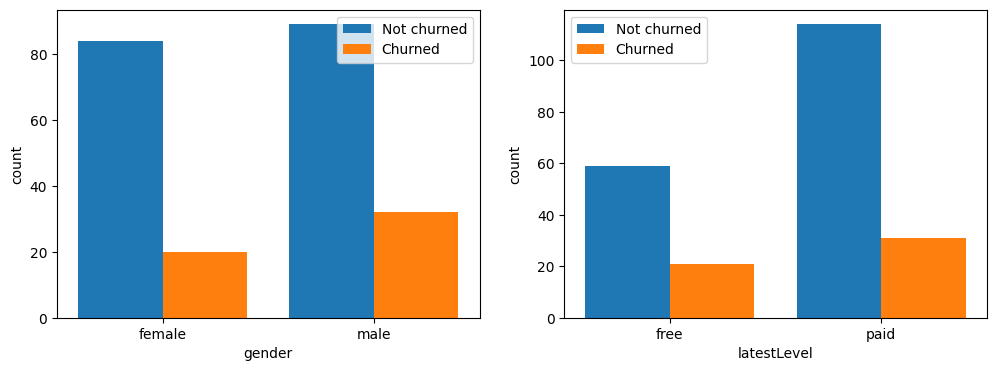

In [262]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.countplot(x='gender', data=user_df_pd, hue='Churn', saturation=1);
plt.legend(['Not churned', 'Churned']);
plt.xticks([0,1], ['female','male'])


plt.subplot(1,2,2)
sns.countplot(x='latestLevel', data=user_df_pd, hue='Churn', saturation=1);
plt.legend(['Not churned', 'Churned'])
plt.xticks([0,1], ['free', 'paid'])

plt.savefig('gender_latest_level_count.png', bbox_inches='tight', dpi=150)

/*****
1. Biểu đồ đặc trưng 'gender' (bên trái):
- sns.countplot(x='gender', data=user_df_pd, hue='Churn', saturation=1): Tạo biểu đồ dạng cột cho đặc trưng 'gender', với mỗi cột hiển thị số lượng người dùng theo giới tính, được phân loại bởi 'Churn'.
- plt.legend(['Not churned', 'Churned']): Hiển thị chú thích cho các giá trị của 'Churn'.
- plt.xticks([0, 1], ['female', 'male']): Đổi tên các nhóm giới tính.
- plt.title('Churn Analysis by Gender'): Đặt tiêu đề cho biểu đồ.
2. Biểu đồ đặc trưng 'latestLevel' (bên phải):
- sns.countplot(x='latestLevel', data=user_df_pd, hue='Churn', saturation=1): Tạo biểu đồ dạng cột cho đặc trưng 'latestLevel', với mỗi cột hiển thị số lượng người dùng theo cấp độ mới nhất, được phân loại bởi 'Churn'.
plt.legend(['Not churned', 'Churned']): Hiển thị chú thích cho các giá trị của 'Churn'.
- plt.xticks([0, 1], ['free', 'paid']): Đổi tên các nhóm cấp độ mới nhất.
- plt.title('Churn Analysis by Latest Level'): Đặt tiêu đề cho biểu đồ.
3. plt.savefig('gender_latest_level_count.png', bbox_inches='tight', dpi=150):
- Lưu biểu đồ thành một file hình ảnh có tên là 'gender_latest_level_count.png' để có thể sử dụng hoặc chia sẻ nó.

Từ biểu đồ, có một sự chênh lệch nhỏ giữa người dùng miễn phí và trả phí về tỷ lệ rời đi. Gói miễn phí có tỷ lệ rời đi cao hơn một chút so với gói trả phí, nhưng vẫn chưa rõ liệu đây có phải là một chênh lệch đáng kể hay không. Ta sẽ tiếp tục kiểm tra các đặc trưng khác để tìm kiếm thông tin chi tiết.

In [263]:
# Hiển thị số lượng người dùng cho mỗi giới tính và trạng thái churn trong một bảng
user_df.select(['gender', 'Churn']).groupBy('gender', 'Churn').count().show()

+------+-----+-----+
|gender|Churn|count|
+------+-----+-----+
|     1|    0|   89|
|     1|    1|   32|
|     0|    0|   84|
|     0|    1|   20|
+------+-----+-----+



In [264]:
# Hiển thị số lượng người dùng theo cấp độ mới nhất và trạng thái churn
user_df.select(['latestLevel', 'Churn']).groupBy('latestLevel', 'Churn').count().show()

+-----------+-----+-----+
|latestLevel|Churn|count|
+-----------+-----+-----+
|          1|    0|  114|
|          1|    1|   31|
|          0|    0|   59|
|          0|    1|   21|
+-----------+-----+-----+



Chúng ta có thể thấy rằng tỷ lệ rời đi chỉ cao hơn một chút đối với người dùng nam (nữ so với nam: 19,2% so với 26,4%) và người dùng miễn phí (miễn phí so với trả phí: 26,3% so với 21,4%).

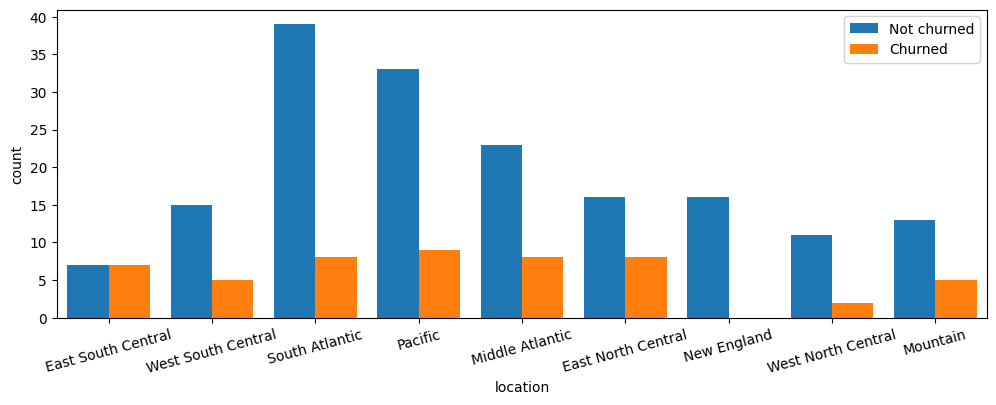

In [265]:
location_churn_df = df.select(['userId', 'location', 'Churn']).dropDuplicates(['userId'])
location_churn_df = location_churn_df.join(region_df, location_churn_df['location']==region_df['State Code'], how='left') \
                    .select(['userId', col("Division").alias("location"), 'Churn'])

# plot location vs. churn
plt.figure(figsize = (12,4))
sns.countplot(x='location', data=location_churn_df.toPandas(), hue='Churn', saturation=1);
plt.xticks(rotation=15)
plt.legend(['Not churned', 'Churned'], loc='upper right');

plt.savefig('location_count.png', bbox_inches='tight', dpi=150)

/****

Tạo một biểu đồ để phân tích mối quan hệ giữa địa điểm (location) và trạng thái churn.

- .select(['userId', 'location', 'Churn']): Chọn các cột 'userId', 'location', và 'Churn' từ DataFrame df.
- .dropDuplicates(['userId']): Loại bỏ các hàng trùng lặp dựa trên cột 'userId'.
- .join(region_df, ...): Kết hợp với DataFrame region_df để thêm thông tin về khu vực địa lý (Division) của người dùng.
- .select(['userId', col("Division").alias("location"), 'Churn']): Chọn các cột 'userId', 'Division' (đã đổi tên thành 'location'), và 'Churn' từ kết quả kết hợp.
- plt.figure(figsize=(12, 4)): Tạo một hình ảnh với kích thước là 12x4 inch để đặt biểu đồ.
- sns.countplot(...): Tạo biểu đồ dạng cột cho địa điểm và trạng thái churn.
- plt.xticks(rotation=15): Xoay nhãn trục x để dễ đọc hơn.
- plt.legend(['Not churned', 'Churned'], loc='upper right'): Hiển thị chú thích cho các giá trị của 'Churn' ở vị trí phía trên bên phải của biểu đồ.
- plt.savefig('location_count.png', bbox_inches='tight', dpi=150): Lưu biểu đồ thành một file hình ảnh có tên là 'location_count.png' để có thể sử dụng hoặc chia sẻ nó.

Có thể nhận thấy rằng tỷ lệ rời đi khác nhau rất nhiều giữa các phân khu. Ví dụ: khu vực New England có tỷ lệ rời đi bằng 0 trong khi số lượng người dùng đã rời đi lại nhiều như chưa rời đi ở khu vực phía Trung Đông Nam.

####  Phân tích mối quan hệ giữa mỗi đặc trưng số (numerical feature) và phản hồi nhị phân

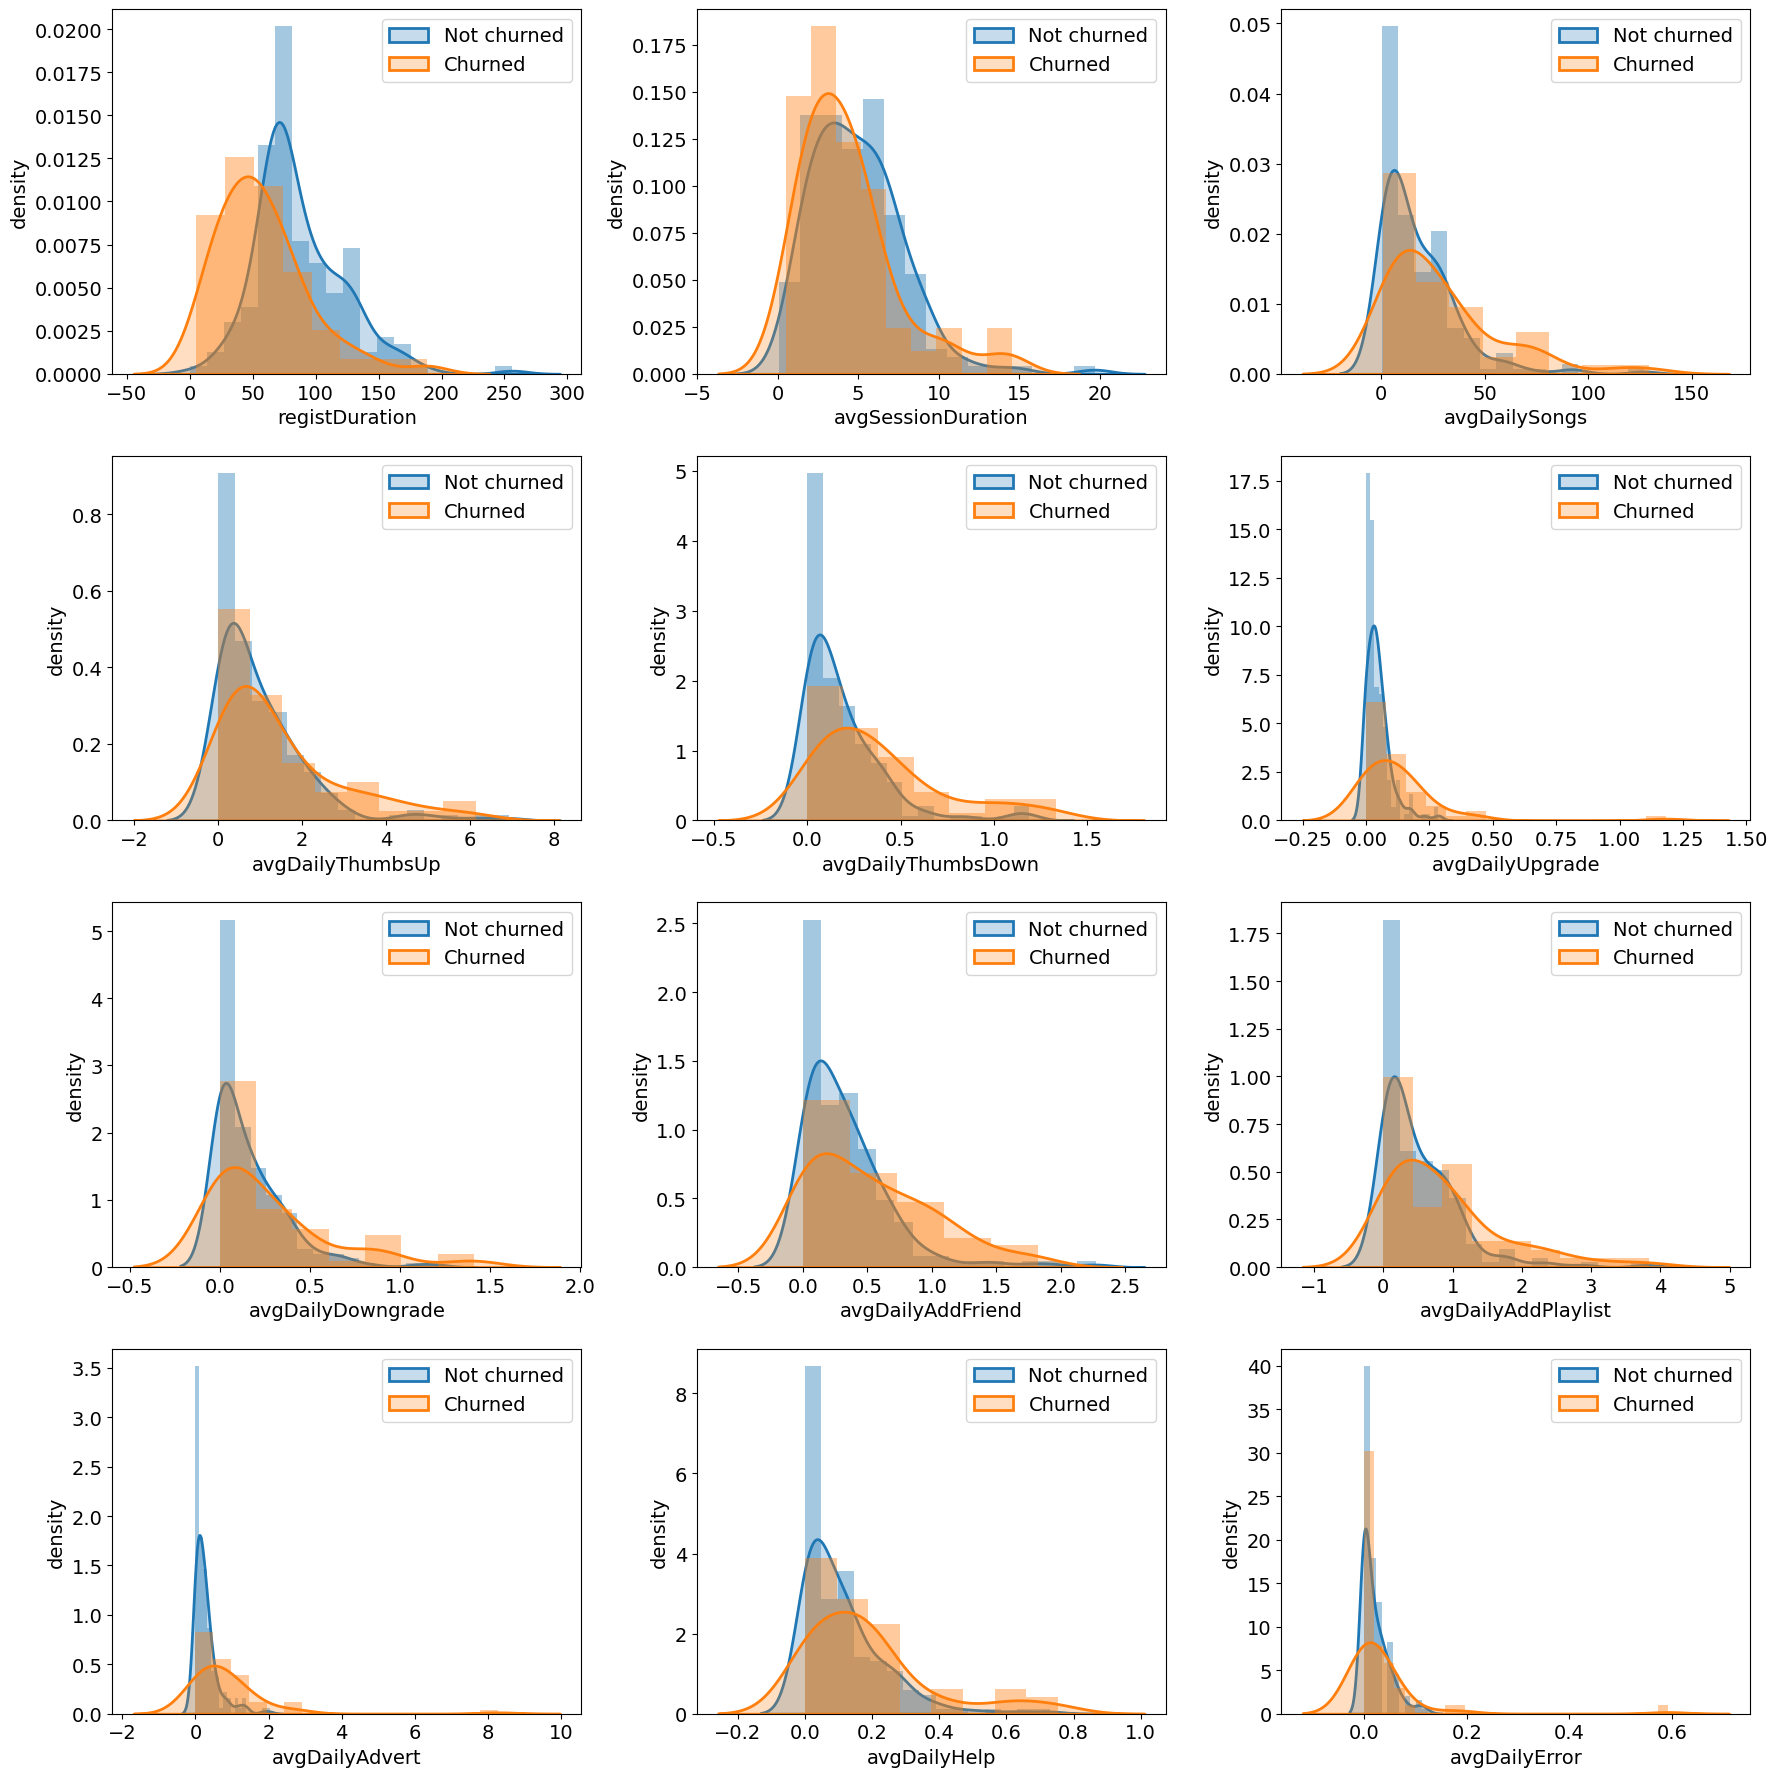

In [266]:
# Lấy danh sách các đặc trưng số
num_cols = [field.name for field in user_df.schema.fields if field.dataType != IntegerType()]

# Tạo biểu đồ cho các đặc trưng số vs. churn
plt.figure(figsize=(18,18))
with plt.style.context({'font.size': 14}):
    for i in range(len(num_cols)):
        plt.subplot(4,3,i+1)
        plt.tight_layout()
        sns.distplot(user_df_pd[user_df_pd['Churn'] == 0][num_cols[i]], kde_kws={'shade':True, 'linewidth':2}, color='C0')
        sns.distplot(user_df_pd[user_df_pd['Churn'] == 1][num_cols[i]], kde_kws={'shade':True, 'linewidth':2}, color='C1')
        plt.legend(['Not churned','Churned'])
        plt.xlabel(num_cols[i])
        plt.ylabel('density')

# Lưu biểu đồ thành file hình ảnh
plt.savefig('numerical_features_hist.png', dpi=150)

/*****

- num_cols: Là danh sách các đặc trưng số từ schema của DataFrame user_df.
- plt.figure(figsize=(18, 18)): Tạo một hình ảnh với kích thước là 18x18 inch để đặt nhiều biểu đồ.
- with plt.style.context({'font.size': 14}): Thay đổi kích thước font tạm thời để làm cho biểu đồ dễ đọc hơn.
- for i in range(len(num_cols)): Duyệt qua từng đặc trưng số để tạo biểu đồ.
- plt.subplot(4, 3, i+1): Chia thành lưới 4x3 biểu đồ, và chọn biểu đồ thứ i+1 để vẽ.
- sns.distplot(...): Vẽ phân phối (histogram) của giá trị của đặc trưng số, phân loại theo trạng thái churn (0: Not churned, 1: Churned).
- plt.legend(['Not churned', 'Churned']): Hiển thị chú thích cho các giá trị churn.
- plt.xlabel(num_cols[i]): Đặt nhãn trục x là tên của đặc trưng số.
- plt.ylabel('density'): Đặt nhãn trục y là "density" (mật độ).
- plt.savefig('numerical_features_hist.png', dpi=150): Lưu biểu đồ thành một file hình ảnh có tên là 'numerical_features_hist.png' để có thể sử dụng hoặc chia sẻ nó.


Chúng ta thấy:

- Người dùng rời đi có trung bình thời gian đăng ký ngắn hơn.
- Người dùng rời đi thường cho nhiều điểm thấp hơn, cần hỗ trợ nhiều hơn, và phải xem nhiều quảng cáo hơn mỗi ngày.
- Không có sự chênh lệch đáng kể giữa người dùng rời đi và không rời đi về trung bình thời lượng phiên.

### Phân tích mối quan hệ tương quan giữa các đặc trưng (feature correlations)

Trước khi bắt đầu mô hình hóa, chúng ta cũng cần hiểu mối quan hệ tương quan giữa biến phản hồi và các đặc trưng cũng như giữa các đặc trưng với nhau. Hàm Correlation trong gói ml.stat yêu cầu một cột kiểu Vector. Do đó, chúng ta cần chuyển đổi các cột thành một cột vector trước, sau đó áp dụng tính tương quan.

In [267]:
vec_col = 'corr_features'

# Tập hợp tất cả các cột vectơ thành một cột vectơ
assembler = VectorAssembler(inputCols=user_df.columns, outputCol=vec_col)
corr_df = assembler.transform(user_df).select(vec_col)

# Tính toán mối tương quan giữa 'churn' và mọi đặc trưng cũng như mối tương quan giữa từng cặp đặc trưng
corr_mat = Correlation.corr(corr_df, vec_col)

# Chuyển đổi ma trận tương quan thành khung dữ liệu pandas
corr_values = corr_mat.collect()[0][0].values
corr_mat_pd = pd.DataFrame(corr_values.reshape(-1, len(user_df.columns)), \
                           index=user_df.columns, columns=user_df.columns)

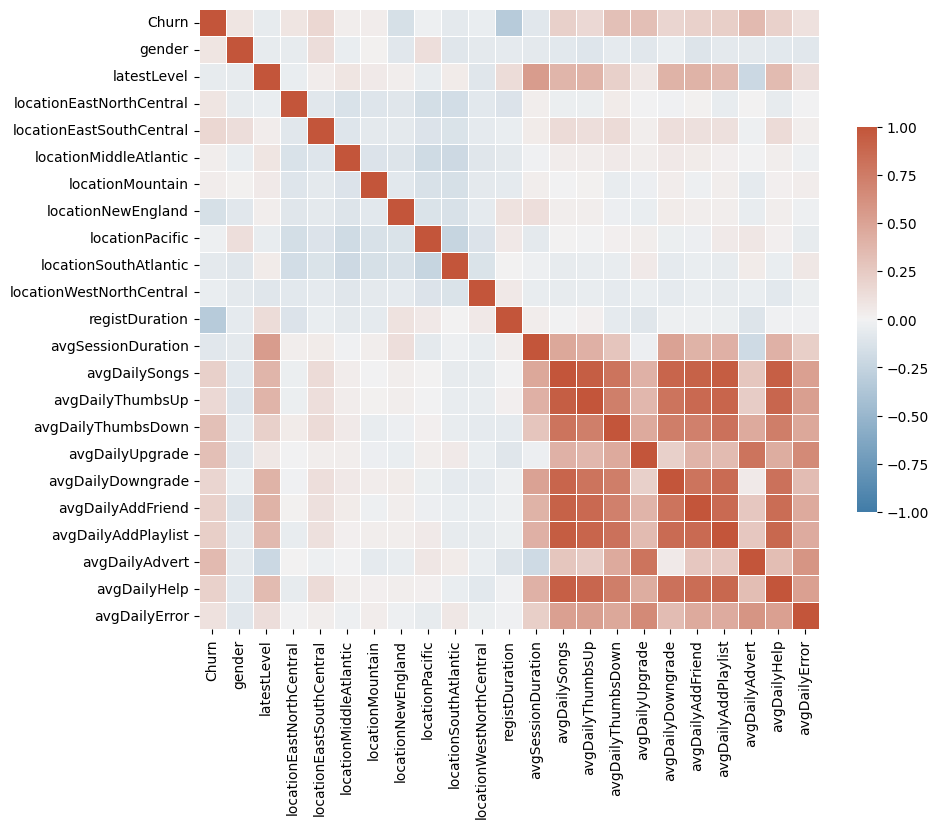

In [268]:
# Vẽ biểu đồ mức độ tương quan giữa các đặc trưng
plt.figure(figsize=(10,10))
sns.heatmap(corr_mat_pd, vmin=-1, vmax=1, cmap=sns.diverging_palette(240, 20, as_cmap=True),
            linewidths=.5, cbar_kws={"shrink": .5}, square=True)
plt.savefig('feature_correlations.png', bbox_inches='tight', dpi=150)


Từ heatmap trên, chúng ta thấy:

- Nhiều hoạt động sự kiện trên trang như **avgDailySongs, avgDailyThumbsUp, avgDailyDowngrade, avgDailyAddFriend, avgDailyAddPlaylist** và **avgDailyHelp**, có mối tương quan cao. Để tránh tình trạng đa cộng tuyến trong dữ liệu, chúng ta chỉ giữ lại **avgDailyAddPlaylist** (vì nó có mối tương quan cao nhất với **Churn**). Ngược lại, các đặc trưng về địa điểm có mối tương quan yếu với nhau.

- **Churn** dường như không có mối tương quan chặt chẽ với bất kỳ đặc trưng nào. **registDuration** có mối tương quan âm với **Churn** trong khi **avgDailyAdvert** có mối tương quan dương cao nhất với **Churn**. Nó cũng cho thấy rằng giới tính (**gender**), cấp độ mới nhất (**latestLevel**), **avgSessionDuration** và nhiều đặc trưng về địa điểm đều có mối tương quan rất thấp với **Churn**. Điều này khớp với các kết quả trước đó thông qua việc trực quan hóa. Tuy nhiên, tương quan Pearson giả định mối quan hệ tuyến tính, và mối tương quan thấp chỉ đơn giản là nói rằng không có mối quan hệ tuyến tính giữa các đặc trưng này và biến phản hồi. Dữ liệu có thể vẫn có mối quan hệ phi tuyến và hiện vẫn nên được đưa vào trong mô hình hóa.

Mã tự động loại bỏ các đặc trưng có tương quan cao được thể hiện như sau:

In [269]:
# Xây dựng ma trận kề nơi mối tương quan cao (> 0.85) được đánh dấu là 1, ngược lại là 0
is_high_corr = np.abs(corr_mat_pd.values) > 0.85
adj_mat = csr_matrix(is_high_corr.astype(int) - np.identity(len(user_df.columns)))

# Tìm nhóm đặc trưng có mối tương quan cao bằng cách tìm thành phần liên thông trong ma trận kề
_, corr_labels = connected_components(csgraph=adj_mat, directed=False)
unique, unique_counts = np.unique(corr_labels, return_counts=True)

# Lấy nhóm có kích thước > 1
high_corr_labels = unique[unique_counts > 1]

# Nếu có ít nhất một nhóm đặc trưng có mối tương quan cao
if len(high_corr_labels) > 0:
    # Ánh xạ các chỉ số nhóm đặc trưng có mối tương quan cao đến tên cột của chúng
    print('Highly correlated features include:')
    high_corr_col_dict = {}
    for high_corr_label in high_corr_labels:
        high_corr_col_dict[high_corr_label] = [col_name for corr_label, col_name in zip(corr_labels, user_df.columns)
                                               if corr_label == high_corr_label]
        print(high_corr_col_dict[high_corr_label])

    print('\nFeatures to keep:')
    cols_to_drop = []
    for col_name_list in high_corr_col_dict.values():
        # Giữ lại đặc trưng có mối tương quan cao nhất với 'Churn'
        col_to_keep = corr_mat_pd.loc[col_name_list,'Churn'].idxmax()
        print(col_to_keep)
        # Loại bỏ các đặc trưng khác để tránh tình trạng đa cộng tuyến
        col_name_list.remove(col_to_keep)
        corr_mat_pd.drop(index=col_name_list, columns=col_name_list, inplace=True)
        cols_to_drop.extend(col_name_list)

Highly correlated features include:
['avgDailySongs', 'avgDailyThumbsUp', 'avgDailyDowngrade', 'avgDailyAddFriend', 'avgDailyAddPlaylist', 'avgDailyHelp']

Features to keep:
avgDailyAddPlaylist


/*****
1. Xây dựng ma trận kề (Build the adjacency matrix):
- Dùng np.abs(corr_mat_pd.values) > 0.85 để xác định những cặp đặc trưng có mối tương quan cao hơn mức 0.85 (mức độ tương quan được tính bằng corr_mat_pd).
- adj_mat = csr_matrix(is_high_corr.astype(int) - np.identity(len(user_df.columns))) chuyển đổi ma trận nhị phân thành ma trận CSR, và trừ một ma trận đơn vị để loại bỏ những đặc trưng tương quan với chính nó.
2. Tìm nhóm đặc trưng có mối tương quan cao (Find groups of highly correlated features):
- Sử dụng connected_components để tìm các nhóm đặc trưng có mối tương quan cao với nhau.
- unique và unique_counts được sử dụng để đếm số lượng thành phần liên thông (connected components) có kích thước lớn hơn 1.
- high_corr_labels là một mảng chứa các nhóm đặc trưng có mối tương quan cao với ít nhất một đặc trưng khác.
3. Xác định và giữ lại đặc trưng (Identify and keep features):
- Nếu có ít nhất một nhóm đặc trưng có mối tương quan cao, tiếp tục xử lý.
high_corr_col_dict là một từ điển ánh xạ nhãn của nhóm đặc trưng đến danh sách các đặc trưng trong nhóm đó.
- Trong mỗi nhóm, giữ lại đặc trưng có mối tương quan cao nhất với 'Churn' và loại bỏ các đặc trưng còn lại.
- Các tên của các đặc trưng cần loại bỏ được thêm vào danh sách cols_to_drop.1

In [270]:
model_df = user_df.drop(*cols_to_drop)
model_df.printSchema()

root
 |-- Churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- latestLevel: integer (nullable = true)
 |-- locationEastNorthCentral: integer (nullable = true)
 |-- locationEastSouthCentral: integer (nullable = true)
 |-- locationMiddleAtlantic: integer (nullable = true)
 |-- locationMountain: integer (nullable = true)
 |-- locationNewEngland: integer (nullable = true)
 |-- locationPacific: integer (nullable = true)
 |-- locationSouthAtlantic: integer (nullable = true)
 |-- locationWestNorthCentral: integer (nullable = true)
 |-- registDuration: double (nullable = true)
 |-- avgSessionDuration: double (nullable = true)
 |-- avgDailyThumbsDown: double (nullable = true)
 |-- avgDailyUpgrade: double (nullable = true)
 |-- avgDailyAddPlaylist: double (nullable = true)
 |-- avgDailyAdvert: double (nullable = true)
 |-- avgDailyError: double (nullable = true)



/*****

 sử dụng drop để loại bỏ các cột được lưu trong cols_to_drop từ DataFrame user_df, và sau đó in ra cấu trúc mới của DataFrame model_df. Các cột trong cols_to_drop được loại bỏ để tạo DataFrame mới, được đặt tên là model_df.

Hiện tại, tổng cộng 10 đặc trưng nhị phân và 7 đặc trưng số đã sẵn sàng để mô hình hóa làm đầu vào.

## Modeling and Evaluation

Đầu tiên ta chia ngẫu nhiên bộ dữ liệu hiện tại thành một tập huấn luyện và tập kiểm tra theo tỉ lệ 8:2 bằng cách sử dụng mẫu phân tầng dựa theo **Churn**.

In [271]:
# chia ngẫu nhiên bộ dữ liệu hiện tại thành một tập huấn luyện và tập kiểm tra theo tỉ lệ 8:2 bằng cách sử dụng mẫu phân tầng dựa theo 'Churn'
train = model_df.sampleBy('Churn', fractions={0: 0.8, 1: 0.8}, seed=2020)
test = model_df.subtract(train)
print('Tập huấn luyện và tập kiểm tra chứa tương ứng {} và {} người dùng, tương tự, trong đó có {} người dùng rời bỏ trong tập kiểm tra.'
      .format(train.count(), test.count(), test.where(col('Churn') == 1).count()))

Tập huấn luyện và tập kiểm tra chứa tương ứng 184 và 38 người dùng, tương tự, trong đó có 11 người dùng rời bỏ trong tập kiểm tra.


Ba bộ phân loại nhị phân được hỗ trợ trong Spark được ưu tiên chọn làm mô hình là: logistic regression, random forest classifier và gradient-boosted tree classifier. Cả random forest và gradient-boosted techniques đều sử dụng một tập hợp các trees quyết định (base estimators) để cải thiện khả năng dự đoán qua một công cụ ước tính duy nhất. Sự khác biệt ở đây là random forest xây dựng một số công cụ ước tính một cách độc lập và sau đó tính trung bình các dự đoán của chúng, trong khi gradient-boosted tree xây dựng các công cụ ước tính cơ sở một cách tuần tự để tạo ra một tập hợp tốt.

### Xây dựng Pipeline huấn luyện

Với mỗi trình phân loại nhị phân, ta xây dựng từng quy trình để tạo điều kiện thuận lợi cho tquy trình học máy và ngăn chặn rò rỉ dữ liệu.

In [272]:
# Xác định các cột số và cột nhóm
num_cols = [field.name for field in model_df.schema.fields if field.dataType != IntegerType()]
bin_cols = [col for col in model_df.columns if col not in num_cols + ['Churn']]

# Tạo một vector từ các cột số
num_assembler = VectorAssembler(inputCols=num_cols, outputCol='num_features')

# Scale các đặc trưng số trong khoảng [0,1]
scaler = MinMaxScaler(inputCol='num_features', outputCol='scaled_features')

# Gom tất cả các đặc trưng thành một vector
assembler = VectorAssembler(inputCols= bin_cols + ['scaled_features'], outputCol='features')

# logistic regression
lr = LogisticRegression(featuresCol='features', labelCol='Churn')
pipeline_lr = Pipeline(stages=[num_assembler, scaler, assembler, lr])

# random forest classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='Churn', seed=2020)
pipeline_rf = Pipeline(stages=[num_assembler, scaler, assembler, rf])

# gradient-boosted tree classifier
gb = GBTClassifier(featuresCol='features', labelCol='Churn', seed=2020)
pipeline_gb = Pipeline(stages=[num_assembler, scaler, assembler, gb])

### Chỉ số hiệu suất

Ta chọn sử dụng **f1 score** làm thước đo hiệu suất vì tập dữ liệu ta xem sét không đảm bảo sự cân bằng. **f1 score** là giá trị trung bình hài hoà về độ precision và recall. Module từ Spark's **MulticlassClassificationEvaluator** trong gói con **ml.evaluation**  chỉ cung cấp số liệu về f1 score, precision và recall có trọng số. Đối với lớp dữ liệu mất cân bằng bởi lớp negative, các chỉ số có trọng số sẽ tăng các chỉ số tương ứng từ lớp positive mà ta quan tâm. Vì lý do này, ta sử dụng module **MulticlassMetrics** từ gói con Spark's **mllib.evaluation** để tính toán các số liệu này cho phù hợp với mỗi lớp. Một số liệu khác mà ta xem xét là **area under the precision-recall curve (AUC-PR)**. Đối với binary classifier evaluation, các precision-recall curves hữu ích hơn các receiver operating characteristic (ROC) curves đối với các vấn đề trong lớp positive được quan tâm hơn là lớp negative.

In [273]:
def print_metrics(pred, label='Churn'):
    """Print evaluation metrics on a test set

    Args:
    pred: (spark dataframe) a test set

    Returns:
    summary: (pandas dataframe) a summary of evaluation metrics
    """

    # lưu trữ các độ đo đánh giá hiệu suất
    eval_metrics = {}

    # Tính diện tích dưới đường Precision-Recall curve
    evaluator = BinaryClassificationEvaluator(labelCol=label)
    auc_pr = evaluator.evaluate(pred, {evaluator.metricName:'areaUnderPR'})

    # Tính precision, recall, và f1 score
    predictionAndLabels = pred.select('prediction', label)
    # Cả 'prediction' và nhãn trong predictionAndLabels cần được chuyển sang kiểu float và
    # ánh xạ thành tuple trước khi gọi 'MulticlassMetrics'
    metrics = MulticlassMetrics(predictionAndLabels.rdd.map(lambda x: tuple(map(float, x))))

    # Lấy thống kê tổng quát
    eval_metrics['overall'] = [metrics.weightedPrecision, metrics.weightedRecall, metrics.weightedFMeasure(), auc_pr]

    # Lấy thống kê theo lớp
    classes = [0.0, 1.0]
    for cls in classes:
        eval_metrics['class ' + str(int(cls))] = [metrics.precision(cls), metrics.recall(cls), metrics.fMeasure(cls), '']

    # Chuyển đổi thành pandas dataframe để hiển thị
    summary = pd.DataFrame.from_dict(eval_metrics, orient='index', \
                                     columns=['precision', 'recall', 'f1 score', 'AUC-PR'])

    return summary

### Điều chỉnh siêu tham số

Điều chỉnh siêu tham số cho không gian tìm kiếm siêu tham số cho ba mô hình được liệt kê dưới đây:

* **Logistic Regression**
    - *maxIter* (Số lần lặp tối đa, default=100): [10, 30]
    - *regParam* (Tham số chính quy, default=0.0): [0.0, 0.1]
    - *elasticNetParam* (Tham số trộn lẫn - 0 for L2 penalty, 1 for L1 penalty, default=0.0): [0.0, 0.5]

* **Random Forest Classifier**
    - *maxDepth* (Độ sâu của cây tối đa, default=5): [4, 5]
    - *numTrees* (Số cây, default=20): [20, 100, 200]

* **Gradient-Boosted Tree Classifier**
    - *maxDepth* (Độ sâu của cây tối đa, default=5): [4, 5]
    - *maxIter* (Số lần lặp tối đa, default=20): [20, 100]

Ta thực hiện tìm kiếm dạng lưới với việc xác thực chéo 4 lần để kiếm tra hiệu suất của các kết hợp siêu tham số được đo bằng **AUC-PR**. Ưu điểm của việc sử dụng AUC-PR là ta không cần phải lo lắng về việc tối ưu hoá ngưỡng xác nhận việc phân chia đầu ra của mô hình thành các dự đoán positive và negative, vì nó tóm tắt hiệu suất của mô hình trên tất cả các ngưỡng có thể xảy ra.

#### Logistic regression

In [274]:
# Thiết lập siêu tham số cho việc điều chỉnh
paramGrid = ParamGridBuilder() \
            .addGrid(lr.maxIter, [10, 30]) \
            .addGrid(lr.regParam, [0.0, 0.1]) \
            .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
            .build()


# tìm kiếm lưới siêu tham số với cross-validation.
crossval_lr = CrossValidator(estimator = pipeline_lr,
                             estimatorParamMaps = paramGrid,
                             evaluator = BinaryClassificationEvaluator(labelCol='Churn', metricName='areaUnderPR'),
                             numFolds = 4)

start = time()
cv_lr = crossval_lr.fit(train)
end = time()
print('Tổng thời gian huấn luyện để tinh chỉnh siêu tham số trên logistic regression: {:.0f} giây'.format(end - start))

Tổng thời gian huấn luyện để tinh chỉnh siêu tham số trên logistic regression: 447 giây


In [275]:
# Lưu kết quả tìm kiếm lưới siêu tham số vào một dataframe
params = [{p.name: v for p, v in m.items()} for m in cv_lr.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['AUC-PR'] = cv_lr.avgMetrics
params_pd

,maxIter,regParam,elasticNetParam,AUC-PR
0,10,0.0,0.0,0.583059
1,10,0.0,0.5,0.583059
2,10,0.1,0.0,0.676952
3,10,0.1,0.5,0.647720
4,30,0.0,0.0,0.584520
5,30,0.0,0.5,0.584520
6,30,0.1,0.0,0.676952
7,30,0.1,0.5,0.647720


In [276]:
# Dự đoán trên tập kiểm tra sử dụng mô hình đã được điều chỉnh
test_prediction = cv_lr.transform(test)

# In ra các độ đo đánh giá hiệu suất
print_metrics(test_prediction)

,precision,recall,f1 score,AUC-PR
overall,0.807966,0.736842,0.647752,0.684777
class 0,0.729730,1.000000,0.843750,
class 1,1.000000,0.090909,0.166667,


#### Random forest classifier

In [277]:
# Thiết lập siêu tham số cho việc điều chỉnh
paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees, [20, 100, 200]) \
            .addGrid(rf.maxDepth, [4, 5]) \
            .build()

# tìm kiếm lưới siêu tham số với cross-validation.
crossval_rf = CrossValidator(estimator = pipeline_rf,
                             estimatorParamMaps = paramGrid,
                             evaluator = BinaryClassificationEvaluator(labelCol='Churn', metricName='areaUnderPR'),
                             numFolds = 4)

start = time()
cv_rf = crossval_rf.fit(train)
end = time()
print('Tổng thời gian huấn luyện để tinh chỉnh siêu tham số trên random forest classifier: {:.0f} giây'.format(end - start))

Tổng thời gian huấn luyện để tinh chỉnh siêu tham số trên random forest classifier: 450 giây


In [278]:
# Lưu kết quả tìm kiếm lưới siêu tham số vào một dataframe
params = [{p.name: v for p, v in m.items()} for m in cv_rf.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['AUC-PR'] = cv_rf.avgMetrics
params_pd

,numTrees,maxDepth,AUC-PR
0,20,4,0.653173
1,20,5,0.640056
2,100,4,0.691386
3,100,5,0.683600
4,200,4,0.705553
5,200,5,0.700081


In [279]:
# Dự đoán trên tập kiểm tra sử dụng mô hình đã được điều chỉnh
test_prediction = cv_rf.transform(test)

# In ra các độ đo đánh giá hiệu suất
print_metrics(test_prediction)

,precision,recall,f1 score,AUC-PR
overall,0.853715,0.815789,0.783376,0.751098
class 0,0.794118,1.000000,0.885246,
class 1,1.000000,0.363636,0.533333,


#### Gradient-boosted tree classifier

In [280]:
# Thiết lập siêu tham số cho việc điều chỉnh
paramGrid = ParamGridBuilder() \
            .addGrid(gb.maxDepth, [4, 5]) \
            .addGrid(gb.maxIter, [20, 100]) \
            .build()

# tìm kiếm lưới siêu tham số với cross-validation.
crossval_gb = CrossValidator(estimator = pipeline_gb,
                             estimatorParamMaps = paramGrid,
                             evaluator = BinaryClassificationEvaluator(labelCol='Churn', metricName='areaUnderPR'),
                             numFolds = 4)

start = time()
cv_gb = crossval_gb.fit(train)
end = time()
print('Tổng thời gian huấn luyện để tinh chỉnh siêu tham số trên Gradient-boosted tree classifier: {:.0f} giây'.format(end - start))

Tổng thời gian huấn luyện để tinh chỉnh siêu tham số trên Gradient-boosted tree classifier: 440 giây


In [281]:
# store grid search results in a dataframe
params = [{p.name: v for p, v in m.items()} for m in cv_gb.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['AUC-PR'] = cv_gb.avgMetrics
params_pd

,maxDepth,maxIter,AUC-PR
0,4,20,0.582935
1,4,100,0.585895
2,5,20,0.587569
3,5,100,0.550390


In [282]:
# Dự đoán trên tập kiểm tra sử dụng mô hình đã được điều chỉnh
test_prediction = cv_gb.transform(test)

# In ra các độ đo đánh giá hiệu suất
print_metrics(test_prediction)

,precision,recall,f1 score,AUC-PR
overall,0.749342,0.763158,0.750693,0.627782
class 0,0.800000,0.888889,0.842105,
class 1,0.625000,0.454545,0.526316,


Kết quả thu được trên tập kiểm tra từ mô hình tốt nhất của từng phân loại được tóm tắt trong bảng dưới đây:
|Classifier                      | Parameters |Precision|          |Recall    |        |F1 score  |        |AUC-PR   |
|:-------------------------------|:-----------|:-------:|----------|:--------:|--------|:--------:|--------|:-------:|
|                                |            |Overall  |Churned   |Overall   |Churned | Overall  |Churned |         |
|Logistic regression             |maxIter=10, regParam=0.1, elasticNetParam=0.5|0.85|1.00|0.82|0.20|0.77|0.33|0.72|
|Random forest classifier        |maxDepth=4, numTrees=100	   |0.86|**0.75**|0.86|**0.60**|**0.86**|**0.67**|**0.77**|   
|Gradient-boosted tree classifier|maxDepth=5, maxIter=100                      |0.77|0.43|0.73|0.60|0.74|0.50|0.65|

Nó cho thấy mô hình random forest classifier hoạt động tốt hơn cả mô hình the logistic regression và gradient-boosted tree classifier trong hầu hết các mục. Như đã nói ở trên, Các đặt điểm và biến phản hồi không tuân theo các mối quan hệ tuyến tính, điều này có thể gợi ý rằng mô hình phi tuyến tính sẽ phù hợp hơn với bộ dữ liệu. Ở ngưỡng xác suất mặc định là 0.5, random forest classifier có thể xác định 60% số người dùng rời bỏ, trong khi 25% được xác định là người dùng khi rời bỏ cảm thấy thật sự hài lòng với dịch vụ. Nếu ta muốn ngắm mục tiêu đến nhiều người dùng có nguy cơ rời bỏ hơn, ta có thể hạ thấp ngưỡng xác suất, và điểm AUC-PR tương đối cao là 0.77 cho phép ta duy trì độ chính xác cao để sẽ không còn nhiều người dùng không có ý định bỏ những chọn nhằm mục tiêu hướng đến.

### Tầm quan trọng của những tính năng

Ta trích xuất tầm quan trọng của các tính năng từ mô hình huấn luyện để hiểu rõ hơn về các thuộc tính tính năng của mô hình trong việc dự đoán tỷ lệ rời bỏ của người dùng.

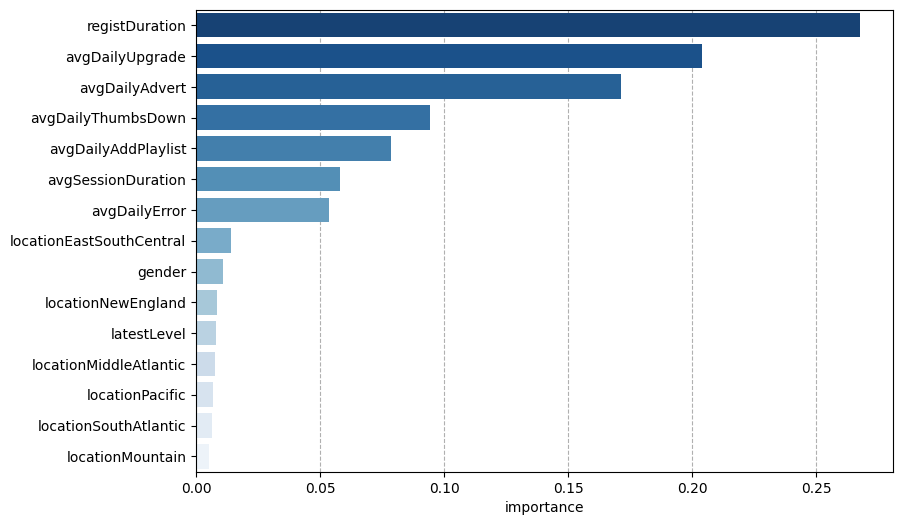

In [283]:
# Tạo danh sách các đặc trưng
features = bin_cols + num_cols

# Lấy độ quan trọng của từng đặc trưng từ mô hình
importances = list(cv_rf.bestModel.stages[-1].featureImportances)

# Tạo DataFrame chứa độ quan trọng của từng đặc trưng
feat_imp_pd = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending = False)

# Vẽ biểu đồ độ quan trọng của đặc trưng
plt.figure(figsize=(9,6))
sns.barplot(data=feat_imp_pd.head(15), y="feature", x="importance", palette='Blues_r', zorder=2)
plt.grid(axis='x', linestyle='--', zorder=0)
plt.ylabel('')
plt.savefig('feature_importance.png', bbox_inches='tight', dpi=150)


Có thể thấy rằng đặc điểm quan trọng nhất để xác định người dùng có ý định rời bỏ là thời hạn đăng ký. Điều này hợp lý vì nó phản ánh trực tiếp ý muốn tiếp tục sử dụng dịch vụ của người dùng. Một tính năng có ảnh hướng khác đóng vai trò quan trọng trong việc dự đoán tỷ lệ rời bỏ là quảng cáo xuất hiện trung bình hàng ngày. Trực quan ta thấy, người dùng càng xem quảng cáo nhiều thì càng có nhiều khả năng họ không hài lòng với dịch vụ. Ngoài ra, mực nâng cấp trung bình và lượt không thích được đưa ra mỗi ngày thể hiện xu hướng mạnh mẽ của người dùng cũng cho thấy ý định rời bỏ.

Kết quả cũng cho thấy việc giới tính, cấp độ đăng ký mới nhất và vị trí cũng góp phần trong việc dự đoán người dùng có ý định rời bỏ hay không. Tuy nhiên, ta nhận thấy tỷ lệ rời bỏ của các tính năng vị trí, chẳng hạn như ở New England và các khu vực phía đông nam trung tâm khác xa so với tỷ lệ rời bỏ trung bình.

## Kết luận

Trong dự án này, nhóm đã sử dụng Python API cho Spark, PySpark, để xác định người dùng rời đi. Quy trình lần lượt từ việc làm sạch và gán nhãn dữ liệu, qua kỹ thuật đặc trưng và loại bỏ các đặc trưng có tương quan cao, đến tinh chỉnh mô hình bằng cách sử dụng tìm kiếm trên lưới với xác thực chéo, đến dự đoán xác suất liên quan đến người dùng có khả năng rời đi.

Về việc chọn mô hình, mô hình Random forest được điều chỉnh với 100 cây và chiều sâu cây tối đa là 4 đạt kết quả tốt nhất với f1 tổng cộng là 0.86. Ở ngưỡng xác suất mặc định là 0.5, hiện tại chúng ta có thể phát hiện được 60% người dùng có khả năng rời đi. Nếu triển khai, mô hình được huấn luyện có thể được sử dụng để dự đoán trước người dùng có dự định rời đi, và chúng ta có thể cung cấp cho họ các ưu đãi đặc biệt hy vọng rằng họ sẽ không xóa tài khoản Sparkify của mình. Ngược lại, 25% người dùng sẽ nhận được ưu đãi đặc biệt nhưng không có dự định chấm dứt dịch vụ, và do đó họ không cần bất kỳ xử lý đặc biệt nào.

Áp dụng vào bộ dữ liệu Sparkify đầy đủ. Nhiệm vụ được thực hiện trên một cụm Amazon Elastic MapReduce (EMR). Với nhiều training data hơn, không gian tìm kiếm của độ sâu cây tối đa và số cây cho bộ phân loại Random forest được điều chỉnh thành [8, 10] và [100, 200] tương ứng.

Ta có thể thấy trên tập dữ liệu mini rằng đặc trưng về giới tính, mức độ đăng ký mới nhất và đặc trưng địa điểm không đáng kể đối với dự đoán mô hình. Khi kiểm thử điều này trên tập dữ liệu đầy đủ và mô hình được train mà không có những đặc trưng này đạt được hiệu suất giống như mô hình bao gồm những đặc trưng này với việc giảm ~40% thời gian tranning. Kết quả được đánh giá trên tập kiểm thử của bộ dữ liệu đầy đủ từ mô hình Random forest tốt nhất được hiển thị dưới đây:


Chúng ta có thể thấy rằng có sự gia tăng đáng kể về hiệu suất trong mọi phân khúc chỉ số do có thêm dữ liệu training. Ở ngưỡng xác suất mặc định là 0.5, mô hình hiện tại có khả năng nhận diện 64% người dùng có khả năng rời đi và 7% được xác định là người dùng rời đi thực sự hài lòng với dịch vụ. Nếu triển khai, mô hình đã train có thể được sử dụng để dự đoán trước người dùng có xu hướng rời đi, và ta có thể cung cấp cho họ các ưu đãi đặc biệt với hy vọng giữ cho họ không xóa tài khoản Sparkify.